## Imports

In [53]:
%matplotlib notebook

import numpy as np
import scipy.signal
import pyabf

import matplotlib.pyplot as plt

import ipywidgets as widgets
import IPython.display

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Load an abf file

For now, we will focus on one file.

TODO: allow analysis across a number of files.


In [54]:
# load a file
path = '/media/cudmore/data/colin/21n10003.abf'
abf = pyabf.ABF(path)

#dataPointsPerMs = abf.dataPointsPerMs
print('recordingDur (sec):', abf.sweepX[-1])
print('dataPointsPerMs (ms):', abf.dataPointsPerMs)
print('sampling frequency (hz):', 1000 * abf.dataPointsPerMs)
print('sampling frequency (kHz):',  abf.dataPointsPerMs)


  _loadAndScaleData using np.fromFile for io.BufferedReader
recordingDur (sec): 82.99990000000001
dataPointsPerMs (ms): 10
sampling frequency (hz): 10000
sampling frequency (kHz): 10


In [55]:
# TODO: we will eventualy specify parameters in ms or sec

def _pntToMs(pnt):
    return pnt / abf.dataPointsPerMs

def _pntToSec(pnt):
    return (pnt / abf.dataPointsPerMs) / 1000

## Plot the raw data

<IPython.core.display.Javascript object>


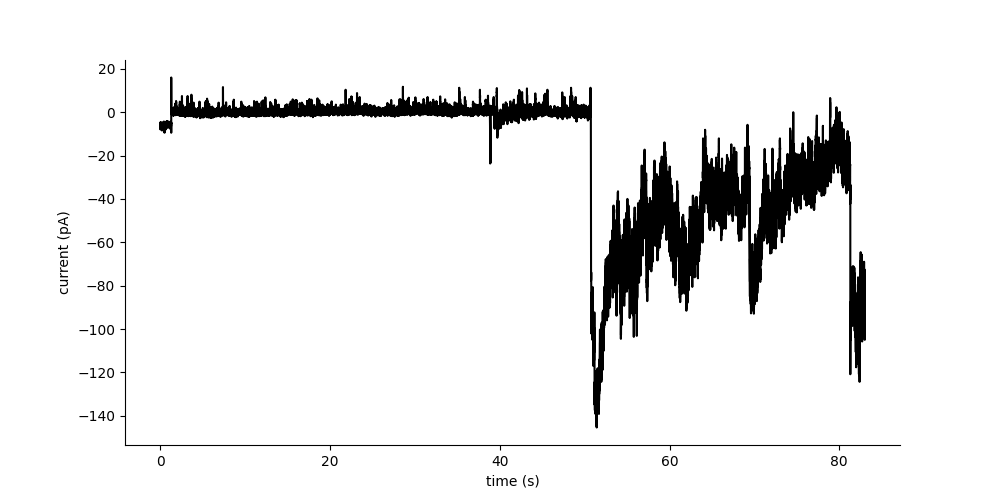

Text(0, 0.5, 'current (pA)')

In [56]:
fig, axs = plt.subplots(1, figsize=(10, 5))

axs.plot(abf.sweepX, abf.sweepY, 'k')

axs.set_xlabel('time (s)')
axs.set_ylabel('current (pA)')



## Select a subset of recoring to analyze.

For this recording, we will look at 0 .. 50.65 (sec)


In [57]:
x = abf.sweepX
y = abf.sweepY

start = 0
stop = 50.65
xRange = np.where(np.logical_and(x>=start, x<=stop)) 

x = x[xRange]
y = y[xRange]

<IPython.core.display.Javascript object>


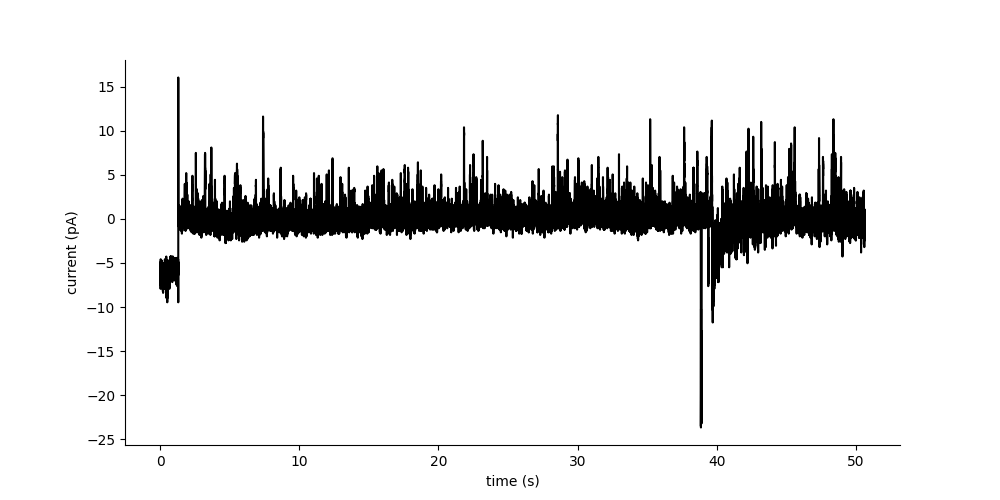

Text(0, 0.5, 'current (pA)')

In [58]:
# plot again

fig, axs = plt.subplots(1, figsize=(10, 5))

axs.plot(x, y, 'k')

axs.set_xlabel('time (s)')
axs.set_ylabel('current (pA)')


## Detect peaks

### This is the important part.

Parameters like (heigth, distance, etc) will depend on each recording and need to be tuned.

In [59]:
# detect peaks (peak, prominence, width)
height = 2
distance = 200 # minimum number of points between peaks
prominence = 1 # could also be [min, max]
width = 50 #100  # [min, max] required

peaks, properties = scipy.signal.find_peaks(y, height=height, distance=distance, prominence=prominence, width=width)

peaks_sec = _pntToSec(peaks)
left_ips = _pntToSec(properties["left_ips"])
right_ips = _pntToSec(properties["right_ips"])

## Plot our results


<IPython.core.display.Javascript object>


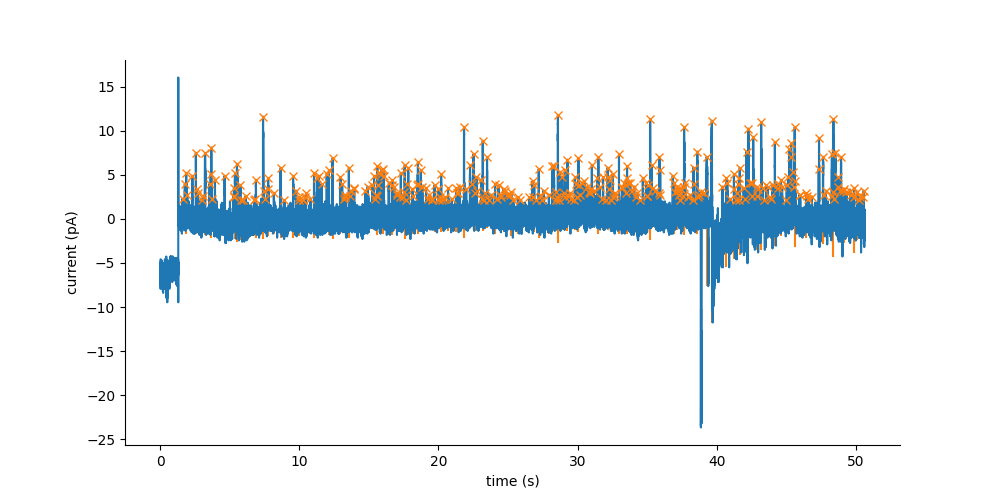

Text(0, 0.5, 'current (pA)')

In [60]:
#plot
fig, axs = plt.subplots(1, figsize=(10, 5))

axs.plot(x, y)
axs.plot(peaks_sec, y[peaks], 'x')

axs.vlines(x=peaks_sec, ymin=y[peaks] - properties["prominences"], ymax = y[peaks], color = "C1")

axs.hlines(y=properties["width_heights"], xmin=left_ips, xmax=right_ips, color = "C1")

axs.set_xlabel('time (s)')
axs.set_ylabel('current (pA)')


## Zoom in to see our results

TODO: Our estimate of peak height is too big. Assuming there is no bias between conditions, we can be confident 'bigger peak' is really bigger peak. We CAN NOT say the peak is a biological constant.

Once we decide on an analysis, this is where SanPy is handy. We can zoom using a point and click GUI.
    

<IPython.core.display.Javascript object>


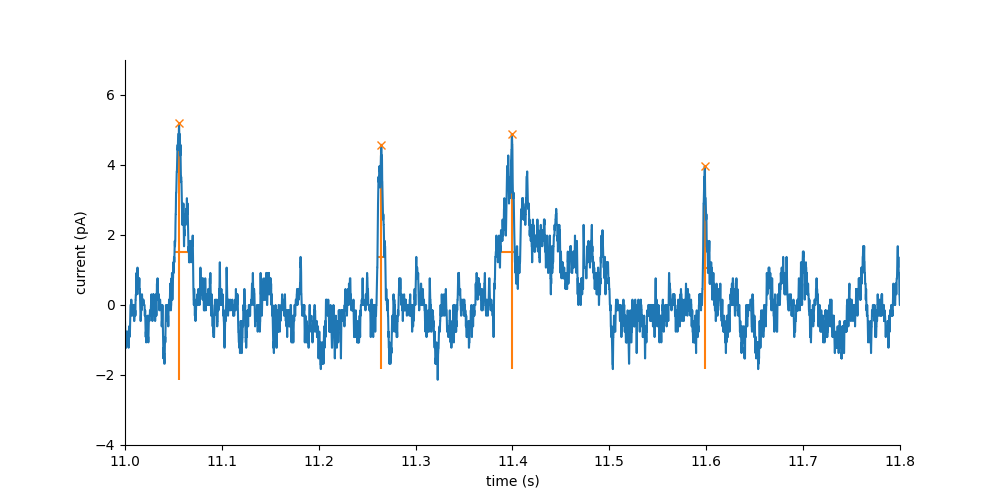

Text(0, 0.5, 'current (pA)')

In [61]:
# TODO: This is a repeat of above code ... make it a function
fig, axs = plt.subplots(1, figsize=(10, 5))

axs.plot(x, y)
axs.plot(peaks_sec, y[peaks], 'x')

axs.vlines(x=peaks_sec, ymin=y[peaks] - properties["prominences"], ymax = y[peaks], color = "C1")

axs.hlines(y=properties["width_heights"], xmin=left_ips, xmax=right_ips, color = "C1")

# set the zoom
axs.set_xlim(11, 11.8)
axs.set_ylim(-4, 7)

axs.set_xlabel('time (s)')
axs.set_ylabel('current (pA)')


## Make it interactive

TODO: Add keystrokes to save (good, bad) for each peak

<IPython.core.display.Javascript object>


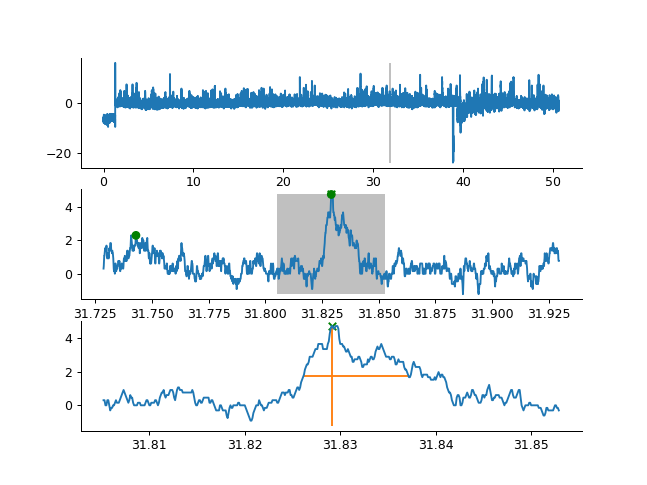

interactive(children=(IntSlider(value=166, description='peakNumber', max=333), IntSlider(value=1005, descripti…

In [85]:
numPeaks = len(peaks)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
axs[0].grid(True)
axs[1].grid(True)

global gPeakNumber
global gZoom1
global gZoom2

# keep track of accept/reject peaks
myAcceptList = [True] * numPeaks

def _pntToSec(pnt):
    if isinstance(pnt, list):
        return [onePnt / abf.dataPointsPerMs / 1000 for onePnt in pnt]
    else:
        return pnt / abf.dataPointsPerMs / 1000

def myReplot():
    myPlotClip(gPeakNumber, gZoom1, gZoom2)
    
def myPlotClip(peakNumber, zoom1, zoom2):
    """
    peakNumber (int)
    zoom1 (int): Points
    zoom2 (int): Points
    """
    global gPeakNumber
    gPeakNumber = peakNumber
    global gZoom1
    gZoom1 = zoom1
    global gZoom2
    gZoom2 = zoom2
    
    windowPnts = zoom2 #300
    windowPnts2 = zoom1 #windowPnts * 5
    
    xPeak = peaks[peakNumber]  # point of the peak
    xPeakSec = _pntToSec(xPeak)
    yPeak = y[xPeak]

    # tight zoom
    xClip = x[xPeak-windowPnts:xPeak+windowPnts]
    yClip = y[xPeak-windowPnts:xPeak+windowPnts]
   

    # bigger view
    xMin = xPeak-windowPnts2  # points
    xMax = xPeak+windowPnts2
    xClip2 = x[xMin:xMax]
    yClip2 = y[xMin:xMax]
   
    # find visible peaks between [xMin, xMax]
    xVisiblePeak_Pnt = [idx for idx,x in enumerate(peaks) if (x>xMin and x<xMax)]  # for scatter colors
    xVisiblePeak = [x for x in peaks if (x>xMin and x<xMax)]
    xVisiblePeakSec = _pntToSec(xVisiblePeak)
    yVisiblePeak = y[xVisiblePeak]
    
    #
    # update plot
    # full view
    axs[0].clear()
    axs[0].plot(x, y, '-')  # bigger view
    rectWidth = max(xClip2) - min(xClip2)  # to match tighter view
    rectHeight = max(y) - min(y)  # does not change
    xRectPos = min(xClip2)  # to match tighter view
    yRectPos = min(y)
    axs[0].add_patch(Rectangle((xRectPos, yRectPos), rectWidth, rectHeight, facecolor="silver"))
    
    # color of selected peak
    mySelectColor = 'g' if myAcceptList[peakNumber] else 'r'
    
    # middle view
    axs[1].clear()
    axs[1].plot(xClip2, yClip2)  # bigger view
    axs[1].scatter(xPeakSec, yPeak, c=mySelectColor, marker='x')
    #axs[1].plot(xVisiblePeakSec, yVisiblePeak, 'o')
    myColors = ['g' if myAcceptList[x] else 'r' for x in xVisiblePeak_Pnt]
    axs[1].scatter(xVisiblePeakSec, yVisiblePeak, c=myColors, zorder=999)
    # gray rectangle
    rectWidth = max(xClip) - min(xClip)  # to match tighter view
    rectHeight = max(yClip2) - min(yClip2)
    xRectPos = min(xClip)  # to match tighter view
    yRectPos = min(yClip2)
    axs[1].add_patch(Rectangle((xRectPos, yRectPos), rectWidth, rectHeight, facecolor="silver"))

    
    # tight view
    axs[2].clear()
    axs[2].plot(xClip, yClip)  # tight zoom
    axs[2].scatter(xPeakSec, yPeak, c=mySelectColor, marker='x')
    axs[2].vlines(x=xPeakSec, ymin=y[xPeak] - properties["prominences"][peakNumber], ymax = y[xPeak], color = "C1")
    
    left_ips = _pntToSec(properties["left_ips"][peakNumber])
    right_ips = _pntToSec(properties["right_ips"][peakNumber])
    axs[2].hlines(y=properties["width_heights"][peakNumber], xmin=left_ips, xmax=right_ips, color = "C1")
    
    fig.canvas.draw()

widgets.interact(myPlotClip, peakNumber=(0,numPeaks,1), zoom1=(10, 2000,1), zoom2=(10, 2000,1));

def on_accept_button_clicked(_):
    myAcceptList[gPeakNumber] = True
    with myOut:
        IPython.display.clear_output()
        print('Accept peak number', gPeakNumber)
    myReplot()
    
def on_reject_button_clicked(_):
    myAcceptList[gPeakNumber] = False
    with myOut:
        IPython.display.clear_output()
        print('Reject peak number', gPeakNumber)
    myReplot()

acceptButton = widgets.Button(description='Accept')
acceptButton.on_click(on_accept_button_clicked)

rejectButton = widgets.Button(description='Reject')
rejectButton.on_click(on_reject_button_clicked)

def on_prev_button(_):
    global gPeakNumber
    gPeakNumber -= 1
    if gPeakNumber < 0:
        gPeakNumber = 0
    myReplot()

prevButton = widgets.Button(description='<')
prevButton.on_click(on_prev_button)
  
def on_next_button(_):
    global gPeakNumber
    gPeakNumber += 1
    if gPeakNumber > numPeaks - 1:
        gPeakNumber = numPeaks - 1
    myReplot()

nextButton = widgets.Button(description='>')
nextButton.on_click(on_next_button)
  
myOut = widgets.Output()
widgets.HBox([prevButton, nextButton, acceptButton, rejectButton, myOut])



## Plot the prominence (amplitude) of each peak versus time

For now, prominence can be though of as the amplitude.

Text(0, 0.5, 'promincance (amplitude)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
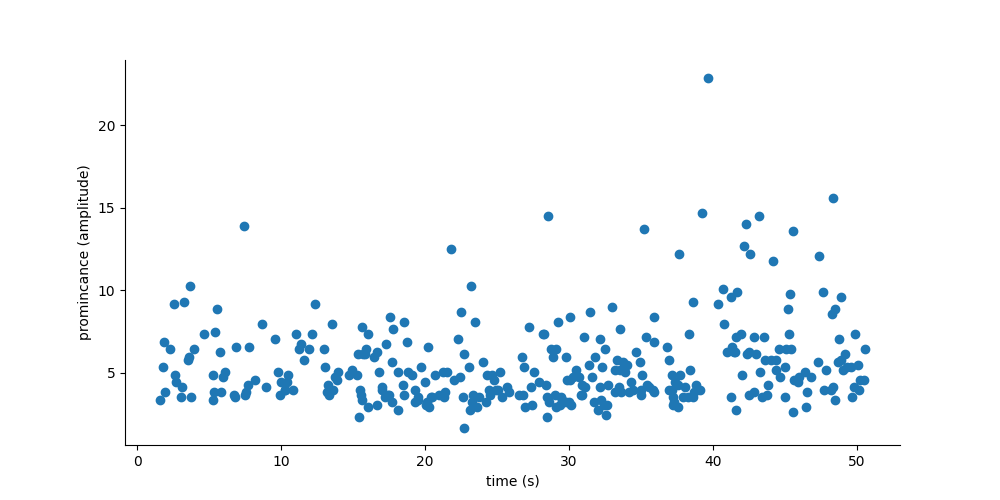

In [10]:
# plot prominence (peak) as function of time
# is this stable?

fig, axs = plt.subplots(1, figsize=(10, 5))

prominences = properties["prominences"]
axs.plot(x[peaks], prominences, 'o')

axs.set_xlabel('time (s)')
axs.set_ylabel('promincance (amplitude)')


## Plot the width of each peak as a function of time


Text(0, 0.5, 'width(ms)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
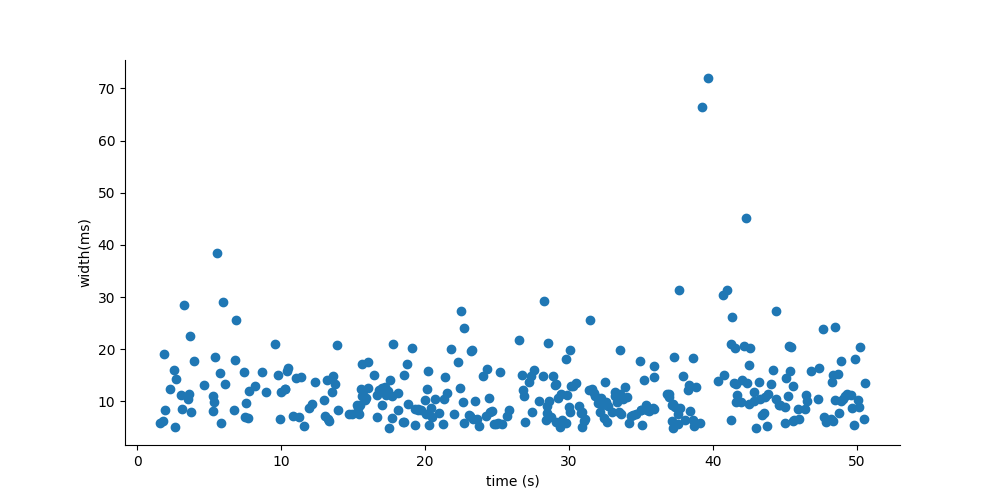

In [11]:
# plot width as function of time
# is this stable?

widths = properties["right_ips"] - properties["left_ips"] # pnts
widths = _pntToMs(widths)

fig, axs = plt.subplots(1, figsize=(10, 5))

axs.plot(x[peaks], widths, 'o')

axs.set_xlabel('time (s)')
axs.set_ylabel('width(ms)')


## For each peak, plot the prominence (amplitude) versus the width

Generally, as the peak gets bigger ... the width gets bigger

Text(0, 0.5, 'width(ms)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
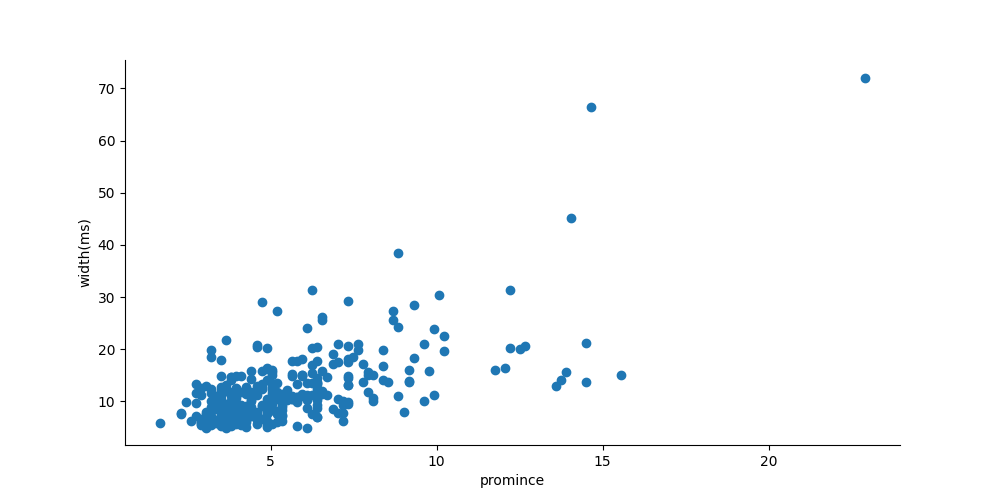

In [12]:
# plot prominence (amplitude) versus width

fig, axs = plt.subplots(1, figsize=(10, 5))

axs.plot(prominences, widths, 'o')

axs.set_xlabel('promince')
axs.set_ylabel('width(ms)')


## Plot the inter event interval as a function of time

Here we are looking for drift in the recording (this is bad)

Text(0, 0.5, 'interval (units ???)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
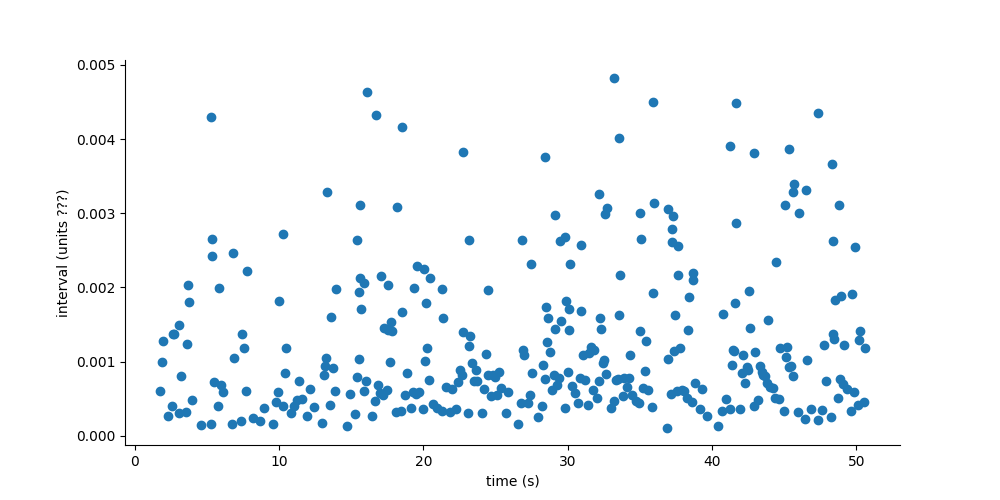

In [13]:
# plot inter-event-interval as a function of recording time

theDiff = np.diff(peaks)
theDiff = 1 / theDiff  # convert intervals to a frewuency (not yet in hz)

peaks2 = peaks[1:]

# plot
fig, axs = plt.subplots(1, figsize=(10, 5))

axs.plot(x[peaks2], theDiff, 'o')

axs.set_xlabel('time (s)')
axs.set_ylabel('interval (units ???)')


In [14]:
# plot the interval versus the amplitude (for now amplitude is prominence, an over-estimate of peak amplitude)

prominences2 = properties["prominences"][1:]
plt.plot(theDiff, prominences2, 'o')

axs.set_xlabel('interval (units ???)')
axs.set_ylabel('promince')

# this tells me there is no historesis. For example, long intervals are not always followed by short intervals.


Text(70.22222222222221, 0.5, 'promince')

In [15]:
# TODO: plot interval and amplitude
# TODO: plot interval versus width

## Make it interactive

TODO: Add keystrokes to save (good, bad) for each peak

<IPython.core.display.Javascript object>


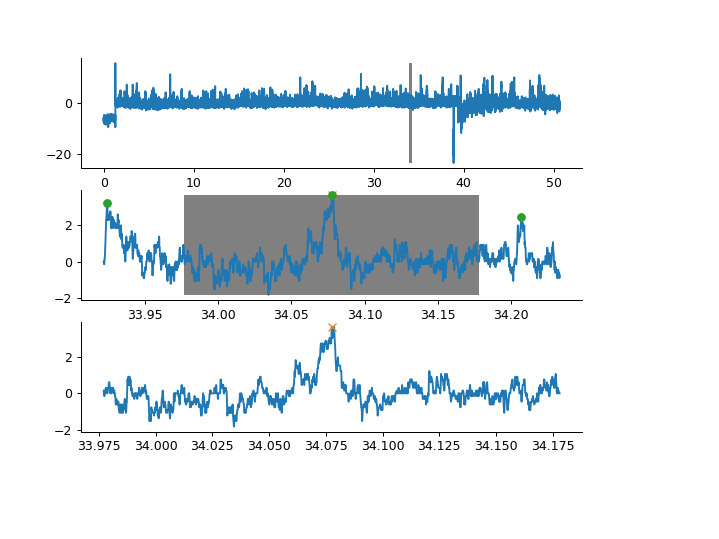

interactive(children=(IntSlider(value=166, description='peakNumber', max=333), IntSlider(value=1005, descripti…

<IPython.core.display.Javascript object>


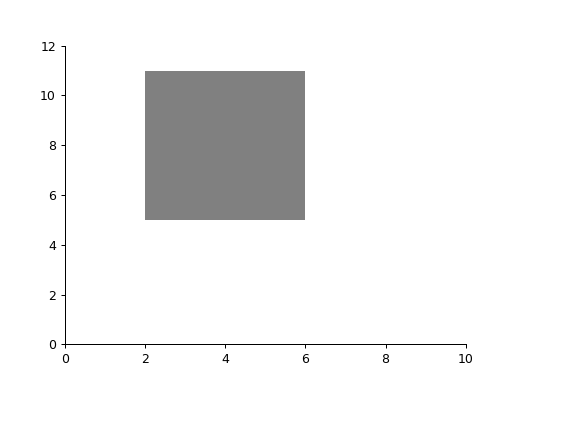

In [36]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

fig = plt.figure()
plt.xlim(0, 10)
plt.ylim(0, 12)

someX, someY = 2, 5
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX, someY), 4, 6, facecolor="grey"))